## Importing libraries

In [2]:
## 2) Code cell — Setup and reproducibility

# 2. Setup and reproducibility

# Standard library
from pathlib import Path
import warnings
import math
import os
import sys
import random
import utils

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Modeling
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    precision_recall_fscore_support,
    confusion_matrix,
    precision_score,
    recall_score
)
from sklearn.calibration import calibration_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Lifelines
from lifelines import CoxPHFitter

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)



## Understanding the Dataset

In [3]:
import pandas as pd

# Path to your local file
path = "brca_metabric_clinical_data.tsv"

# Load the dataset
df = pd.read_csv(path, sep="\t")

# Preview the data
df.head()

,Study ID,Patient ID,Sample ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,...,Relapse Free Status (Months),Relapse Free Status,Number of Samples Per Patient,Sample Type,Sex,3-Gene classifier subtype,TMB (nonsynonymous),Tumor Size,Tumor Stage,Patient's Vital Status
0,brca_metabric,MB-0000,MB-0000,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,NO,claudin-low,...,140.500000,0:Not Recurred,1,Primary,Female,ER-/HER2-,0.000000,22.0,2.0,Living
1,brca_metabric,MB-0002,MB-0002,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,NO,LumA,...,84.633333,0:Not Recurred,1,Primary,Female,ER+/HER2- High Prolif,2.615035,10.0,1.0,Living
2,brca_metabric,MB-0005,MB-0005,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,YES,LumB,...,153.300000,1:Recurred,1,Primary,Female,NaN,2.615035,15.0,2.0,Died of Disease
3,brca_metabric,MB-0006,MB-0006,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,YES,LumB,...,164.933333,0:Not Recurred,1,Primary,Female,NaN,1.307518,25.0,2.0,Living
4,brca_metabric,MB-0008,MB-0008,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,YES,LumB,...,18.800000,1:Recurred,1,Primary,Female,ER+/HER2- High Prolif,2.615035,40.0,2.0,Died of Disease


In [4]:
# Column types
df.info()

# Summary statistics for numeric columns
df.describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Study ID                        2509 non-null   object 
 1   Patient ID                      2509 non-null   object 
 2   Sample ID                       2509 non-null   object 
 3   Age at Diagnosis                2498 non-null   float64
 4   Type of Breast Surgery          1955 non-null   object 
 5   Cancer Type                     2509 non-null   object 
 6   Cancer Type Detailed            2509 non-null   object 
 7   Cellularity                     1917 non-null   object 
 8   Chemotherapy                    1980 non-null   object 
 9   Pam50 + Claudin-low subtype     1980 non-null   object 
 10  Cohort                          2498 non-null   float64
 11  ER status measured by IHC       2426 non-null   object 
 12  ER Status                       24

,count,mean,std,min,25%,50%,75%,max
Age at Diagnosis,2498.0,60.420300,13.032997,21.93,50.920000,61.110000,70.000000,96.290000
Cohort,2498.0,2.900320,1.962216,1.00,1.000000,3.000000,4.000000,9.000000
Neoplasm Histologic Grade,2388.0,2.412060,0.649363,1.00,2.000000,3.000000,3.000000,3.000000
Lymph nodes examined positive,2243.0,1.950513,4.017774,0.00,0.000000,0.000000,2.000000,45.000000
Mutation Count,2358.0,5.590755,3.989171,1.00,3.000000,5.000000,7.000000,81.000000
Nottingham prognostic index,2287.0,4.028787,1.189092,1.00,3.048000,4.044000,5.040000,7.200000
Overall Survival (Months),1981.0,125.244271,76.111772,0.00,60.866667,116.466667,185.133333,355.200000
Relapse Free Status (Months),2388.0,110.293649,77.539698,0.00,41.100000,100.416667,169.875000,389.333333
Number of Samples Per Patient,2509.0,1.000000,0.000000,1.00,1.000000,1.000000,1.000000,1.000000
TMB (nonsynonymous),2509.0,6.849746,5.320394,0.00,3.922553,6.537589,9.152624,104.601416


In [5]:
# Count of missing values
df.isnull().sum().sort_values(ascending=False)


3-Gene classifier subtype         745
Tumor Stage                       721
Primary Tumor Laterality          639
Cellularity                       592
Type of Breast Surgery            554
Integrative Cluster               529
HER2 status measured by SNP6      529
Radio Therapy                     529
PR Status                         529
Inferred Menopausal State         529
Hormone Therapy                   529
HER2 Status                       529
Patient's Vital Status            529
Pam50 + Claudin-low subtype       529
Chemotherapy                      529
Overall Survival Status           528
Overall Survival (Months)         528
Lymph nodes examined positive     266
Nottingham prognostic index       222
Mutation Count                    151
Tumor Size                        149
Tumor Other Histologic Subtype    135
Relapse Free Status (Months)      121
Neoplasm Histologic Grade         121
ER status measured by IHC          83
ER Status                          40
Relapse Free

## Removing N/A values from the dataset

In [6]:
import pandas as pd
import numpy as np

# Load
df = pd.read_csv(path, sep="\t")

survival_cols = ["Overall Survival (Months)", "Overall Survival Status"]
df = df.dropna(subset=survival_cols)

print("Dataset size after removing missing survival:", df.shape)


categorical_cols = df.select_dtypes(include=["object"]).columns
numeric_cols = df.select_dtypes(include=["number"]).columns

# Optional: manually ensure correct classification
categorical_cols = categorical_cols.tolist()
numeric_cols = numeric_cols.tolist()


df[categorical_cols] = df[categorical_cols].fillna("Unknown")


for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())


print(df.isnull().sum().sort_values(ascending=False))


Dataset size after removing missing survival: (1981, 39)
Study ID                          0
Relapse Free Status (Months)      0
Mutation Count                    0
Nottingham prognostic index       0
Oncotree Code                     0
Overall Survival (Months)         0
Overall Survival Status           0
PR Status                         0
Radio Therapy                     0
Relapse Free Status               0
Primary Tumor Laterality          0
Number of Samples Per Patient     0
Sample Type                       0
Sex                               0
3-Gene classifier subtype         0
TMB (nonsynonymous)               0
Tumor Size                        0
Tumor Stage                       0
Lymph nodes examined positive     0
Integrative Cluster               0
Patient ID                        0
Pam50 + Claudin-low subtype       0
Sample ID                         0
Age at Diagnosis                  0
Type of Breast Surgery            0
Cancer Type                       0
Cancer 

##### In order to remove the missing values without creating bias/imbalance among the varaibles we replace the missing values with "Unknown" while droping the overall survival status values that were missing.

## Preprocessing/Splitting

In [7]:
# Create event column (1 = died, 0 = living)
df['event'] = df["Overall Survival Status"].apply(lambda x: 1 if "1:DECEASED" in x else 0)

# Survival time column
df['time'] = df["Overall Survival (Months)"]


In [8]:
# Define features and survival outcomes
X = df.drop(columns=["time", "event", "Overall Survival (Months)", "Overall Survival Status"])
y_time = df["time"]
y_event = df["event"]

# Train/test split WITH stratification on event indicator
X_train, X_test, y_time_train, y_time_test, y_event_train, y_event_test = train_test_split(
    X, y_time, y_event,
    test_size=0.2,
    random_state=42,
    stratify=y_event
)

print("The following code uses a specific kind of spliting technique for the first model, use the regular kind when preparing your own model")

The following code uses a specific kind of spliting technique for the first model, use the regular kind when preparing your own model


In [9]:
df["Overall Survival Status"].value_counts()
#df["Overall Survival Status"].unique()


Overall Survival Status
1:DECEASED    1144
0:LIVING       837
Name: count, dtype: int64

In [10]:
# count the occurrences of each unique value in the 'event' column
df["event"].value_counts()

event
1    1144
0     837
Name: count, dtype: int64

## Kaplan–Meier curves Model

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts

# Fit KM for all patients
kmf = KaplanMeierFitter(label="All METABRIC patients")
kmf.fit(durations=df["time"], event_observed=df["event"])

# Optional: look at the survival function table
kmf.survival_function_.head()


,All METABRIC patients
timeline,
0.000000,1.000000
0.100000,0.999495
0.766667,0.999495
1.233333,0.999495
1.266667,0.999495


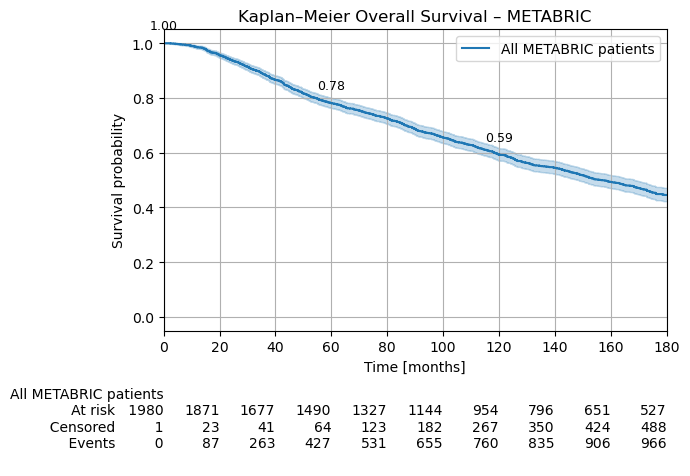

In [12]:
# Plot
fig, ax = plt.subplots(figsize=(7, 5))

# Survival curve
kmf.plot_survival_function(ax=ax)
ax.set_title("Kaplan–Meier Overall Survival – METABRIC")
ax.set_xlabel("Time [months]")
ax.set_ylabel("Survival probability")

# Add gridlines
ax.grid(True)

# Zoom in: e.g. first 180 months (15 years) for clarity
ax.set_xlim(0, 180)

# Annotate selected time points in months (e.g., 0, 60, 120)
time_points = [0, 60, 120]

for t in time_points:
    # Find the closest time index in the survival function
    idx = kmf.survival_function_.index.get_indexer([t], method="nearest")[0]
    t_closest = kmf.survival_function_.index[idx]
    y = kmf.survival_function_.iloc[idx, 0]

    ax.annotate(f"{y:.2f}",
                xy=(t_closest, y),
                xytext=(0, 10),
                textcoords="offset points",
                ha='center',
                fontsize=9,
                color="black")

# Add at-risk counts under the plot
add_at_risk_counts(kmf, ax=ax)

plt.tight_layout()
plt.show()


##### The graph above showcases the overall survival probabilty among the patients up to 180 months. We can see that the survival rate gradually decreases in the course of time as in 60 months (5 years) the survival rate is 78%, in 120 months (10 years) the survival rate is 59% and at 180 months (15 years) about 45% remain alive.

##### Below the graph tells us the amount of patients who are at risk, the patients who are alive at their last follow up or were lost to follow up (censored), and the patients who were confirmed dead from the cancer (events) over the months. As you can see the patients at risk gradually decreases as they are either successfully treated, lost or have passed away.

### Median Survival Time

In [13]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter(label="All METABRIC patients")
kmf.fit(df["time"], event_observed=df["event"])

median_survival_time = kmf.median_survival_time_
print(f"The median survival time for the METABRIC cohort is: {median_survival_time:.1f} months")


The median survival time for the METABRIC cohort is: 156.3 months


### Restricted Mean Survival Time

In [14]:
from lifelines import KaplanMeierFitter
from lifelines.utils import restricted_mean_survival_time
import pandas as pd

km_overall = KaplanMeierFitter(label="All METABRIC patients").fit(
    df["time"].clip(lower=0),
    df["event"]
)

horizons = [60.0, 120.0, 180.0]

rows = []
for t0 in horizons:
    rmst_val = restricted_mean_survival_time(km_overall, t=t0)
    rows.append({
        "t0 [months]": int(t0),
        "RMST [months]": round(float(rmst_val), 1)
    })

rmst_table = pd.DataFrame(rows)
display(rmst_table)


,t0 [months],RMST [months]
0,60,54.4
1,120,95.7
2,180,126.7


##### We can see that on average ~ 54 patients survive up for 60 months (5 years), ~ 95 patients survive up for 120 months (10 years), and ~ 126 patients survive for 180 months (15 years). 

### Subgroup Reading

In [15]:
candidates = [
    "Age at Diagnosis",
    "Tumor Stage",
    "Neoplasm Histologic Grade",
    "ER Status",
    "PR Status",
    "HER2 Status",
    "Hormone Therapy",
    "Chemotherapy",
    "Radio Therapy"
]

cols = [c for c in candidates if c in df.columns] + ["time", "event"]

display(df[cols].head(8))
display(df[cols].isna().mean().sort_values(ascending=False).to_frame("missing_rate"))

print("Event rate =", df["event"].mean())


,Age at Diagnosis,Tumor Stage,Neoplasm Histologic Grade,ER Status,PR Status,HER2 Status,Hormone Therapy,Chemotherapy,Radio Therapy,time,event
0,75.65,2.0,3.0,Positive,Negative,Negative,YES,NO,YES,140.500000,0
1,43.19,1.0,3.0,Positive,Positive,Negative,YES,NO,YES,84.633333,0
2,48.87,2.0,2.0,Positive,Positive,Negative,YES,YES,NO,163.700000,1
3,47.68,2.0,2.0,Positive,Positive,Negative,YES,YES,YES,164.933333,0
4,76.97,2.0,3.0,Positive,Positive,Negative,YES,YES,YES,41.366667,1
5,78.77,4.0,3.0,Positive,Positive,Negative,YES,NO,YES,7.800000,1
6,56.45,2.0,2.0,Positive,Positive,Negative,YES,YES,YES,164.333333,0
7,70.00,3.0,3.0,Negative,Negative,Negative,NO,YES,YES,22.400000,1


,missing_rate
Age at Diagnosis,0.0
Tumor Stage,0.0
Neoplasm Histologic Grade,0.0
ER Status,0.0
PR Status,0.0
HER2 Status,0.0
Hormone Therapy,0.0
Chemotherapy,0.0
Radio Therapy,0.0
time,0.0


Event rate = 0.5774861181221606


In [16]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test

def km_by_group(data, group_col, title=None, order=None, drop_unknown=True):
    """
    Plot KM curves by levels of `group_col` and run a log-rank test.
    """
    df_sub = data.copy()

    # Optionally drop "Unknown" category if you used that for imputation
    if drop_unknown and "Unknown" in df_sub[group_col].values:
        df_sub = df_sub[df_sub[group_col] != "Unknown"]

    # Drop rows with missing in the grouping variable
    df_sub = df_sub.dropna(subset=[group_col])

    kmf = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(7, 5))

    # Determine plotting order
    groups = df_sub[group_col].unique()
    if order is not None:
        groups = [g for g in order if g in groups]

    for g in groups:
        mask = df_sub[group_col] == g
        kmf.fit(df_sub.loc[mask, "time"],
                event_observed=df_sub.loc[mask, "event"],
                label=str(g))
        kmf.plot_survival_function(ax=ax)

    ax.set_title(title or f"Kaplan–Meier survival by {group_col}")
    ax.set_xlabel("Time [months]")
    ax.set_ylabel("Survival probability")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    # Global log-rank test across all groups
    res = multivariate_logrank_test(
        df_sub["time"],
        df_sub[group_col],
        df_sub["event"]
    )
    print(f"Log-rank p-value for {group_col}: {res.p_value:.4g}")


Unique Tumor Stages: [2. 1. 4. 3. 0.]


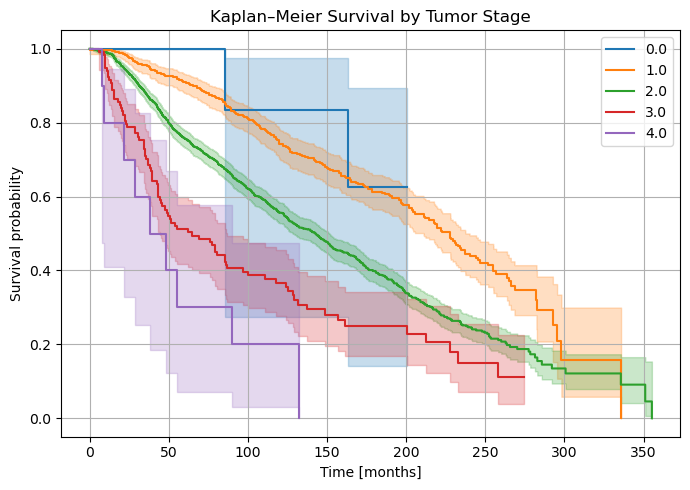

Log-rank p-value for Tumor Stage: 5.883e-28


In [17]:
print("Unique Tumor Stages:", df["Tumor Stage"].unique())

# If Tumor Stage is numeric, sort it; if it's strings like '1', '2', '3', this still works.
stages_order = sorted(
    [s for s in df["Tumor Stage"].dropna().unique()]
)

km_by_group(
    df,
    group_col="Tumor Stage",
    title="Kaplan–Meier Survival by Tumor Stage",
    order=stages_order
)


##### The graph above visualizes the survival rate of patients with different tumor stages.

Unique Chemotherapy values: ['NO' 'YES' 'Unknown']


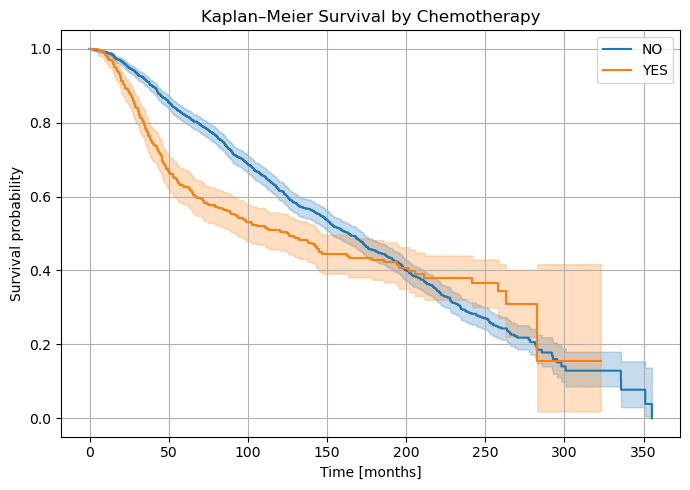

Log-rank p-value for Chemotherapy: 0.001794


In [18]:
print("Unique Chemotherapy values:", df["Chemotherapy"].unique())
# Typically something like: ['YES', 'NO', 'Unknown']

chemo_order = ["NO", "YES", "Unknown"]

km_by_group(
    df,
    group_col="Chemotherapy",
    title="Kaplan–Meier Survival by Chemotherapy",
    order=chemo_order
)


#####

Unique ER Status values: ['Positive' 'Negative']


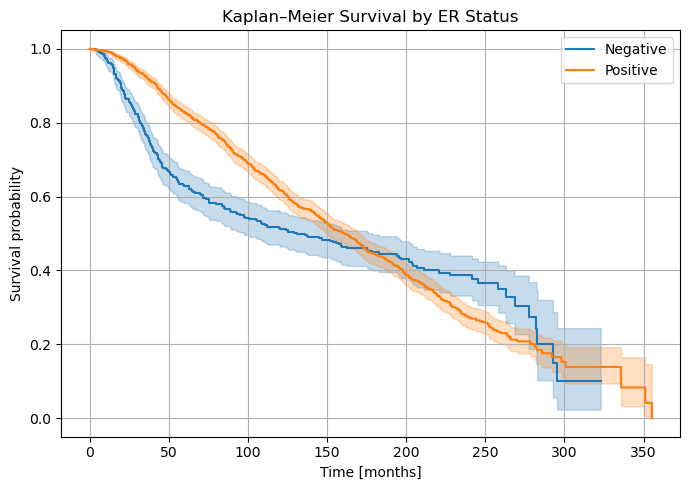

Log-rank p-value for ER Status: 0.03505


In [19]:
print("Unique ER Status values:", df["ER Status"].unique())
# Often: ['Positive', 'Negative', 'Unknown']

er_order = ["Negative", "Positive", "Unknown"]

km_by_group(
    df,
    group_col="ER Status",
    title="Kaplan–Meier Survival by ER Status",
    order=er_order
)


#####

## Cox Proportional Hazard Model

In [20]:
import seaborn as sns
from lifelines import CoxPHFitter
import pandas as pd
from lifelines.utils import concordance_index
from lifelines.plotting import add_at_risk_counts
SKSURV_AVAILABLE = False
try:
    from sksurv.metrics import cumulative_dynamic_auc, integrated_brier_score
    from sksurv.util import Surv
    SKSURV_AVAILABLE = True
except ImportError as e:
    print("scikit-survival not available. Time-dependent metrics will be skipped.")
    print(f"Import error: {e}")
from sksurv.metrics import cumulative_dynamic_auc, brier_score
from sklearn.isotonic import IsotonicRegression

In [21]:
# Candidate variables for Cox PH model
candidates = ['time',
    'event',
    'Tumor Size',
    'Tumor Stage',
    'Chemotherapy',
    'Hormone Therapy',
    'Radio Therapy',
    'ER Status']

df_CPH = df[candidates].copy()
df_CPH.head()

,time,event,Tumor Size,Tumor Stage,Chemotherapy,Hormone Therapy,Radio Therapy,ER Status
0,140.500000,0,22.0,2.0,NO,YES,YES,Positive
1,84.633333,0,10.0,1.0,NO,YES,YES,Positive
2,163.700000,1,15.0,2.0,YES,YES,NO,Positive
3,164.933333,0,25.0,2.0,YES,YES,YES,Positive
4,41.366667,1,40.0,2.0,YES,YES,YES,Positive


PreProcessing Steps

In [22]:
# Prepare categorical variables
# Tumor Stage - convert to ordered categorical
stage_order = sorted(df_CPH['Tumor Stage'].dropna().unique())
df_CPH['Tumor Stage'] = pd.Categorical(
    df_CPH['Tumor Stage'],
    categories=stage_order,
    ordered=True
)

# CHemotherapy, Hormone Therapy, Radio Therapy, ER Status - convert to binary categorical
binary_cols = ['Chemotherapy', 'Hormone Therapy', 'Radio Therapy', 'ER Status']
for col in binary_cols:
    df_CPH[col] = df_CPH[col].map({'YES': 1, 'NO': 0, 'Positive': 1, 'Negative': 0, 'Unknown': np.nan})

#show the prepared data
df_CPH.head()


,time,event,Tumor Size,Tumor Stage,Chemotherapy,Hormone Therapy,Radio Therapy,ER Status
0,140.500000,0,22.0,2.0,0.0,1.0,1.0,1.0
1,84.633333,0,10.0,1.0,0.0,1.0,1.0,1.0
2,163.700000,1,15.0,2.0,1.0,1.0,0.0,1.0
3,164.933333,0,25.0,2.0,1.0,1.0,1.0,1.0
4,41.366667,1,40.0,2.0,1.0,1.0,1.0,1.0


Training and Test Split

In [23]:
Y = df_CPH[['time', 'event']]
X = df_CPH.drop(columns=['time', 'event'])

X_train, X_holdout, Y_train, Y_holdout = train_test_split(
    X, Y,
    train_size=0.7,
    random_state=SEED,
    stratify=Y['event']
)

X_val, X_test, Y_val, Y_test = train_test_split(
    X_holdout, Y_holdout,
    test_size=0.33,
    random_state=SEED,
    stratify=Y_holdout['event']
)

print("--- Data Splitting Report ---")
print(f"Training set   : {len(X_train)} rows ({len(X_train) / len(df_CPH):.0%})")
print(f"Validation set : {len(X_val)} rows ({len(X_val) / len(df_CPH):.0%})")
print(f"Test set       : {len(X_test)} rows ({len(X_test) / len(df_CPH):.0%})")

CPH_train = pd.concat([Y_train.reset_index(drop=True), X_train.reset_index(drop=True)], axis=1)
CPH_val = pd.concat([Y_val.reset_index(drop=True), X_val.reset_index(drop=True)], axis=1)
CPH_test = pd.concat([Y_test.reset_index(drop=True), X_test.reset_index(drop=True)], axis=1)

#for some reason, there are NaNs in the validation set after splitting, so we drop them here
CPH_val = CPH_val.dropna()

--- Data Splitting Report ---
Training set   : 1386 rows (70%)
Validation set : 398 rows (20%)
Test set       : 197 rows (10%)


CoxModel Fitting

In [24]:
# Safety checks
for name in ["X_train", "X_val", "Y_train", "Y_val"]:
    if name not in globals():
        raise NameError(f"{name} not defined. Ensure section 3.2 ran successfully")

# 4) Fit Cox PH with Efron ties and a small L2 penalizer for stability
cph_multi = CoxPHFitter(penalizer=0.01)
cph_multi.fit(CPH_train, duration_col="time", event_col="event")

print("--- Multivariable Cox model summary ---")
cph_multi.print_summary(
    decimals=3,
    columns=["coef", "exp(coef)", "exp(coef) lower 95%", "exp(coef) upper 95%", "p"]
)

# 5) Concordance baseline
cindex_train = float(cph_multi.concordance_index_)
cindex_val = float(cph_multi.score(CPH_val, scoring_method="concordance_index"))
print(f"\nConcordance | train {cindex_train:.3f} | validation {cindex_val:.3f}")


--- Multivariable Cox model summary ---


<lifelines.CoxPHFitter: fitted with 1386 total observations, 586 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1386
number of events observed = 800
   partial log-likelihood = -5147.935
         time fit was run = 2025-12-04 19:45:22 UTC

---
                  coef exp(coef) exp(coef) lower 95% exp(coef) upper 95%       p
covariate                                                                       
Tumor Size       0.008     1.008               1.004               1.012 <0.0005
Tumor Stage      0.538     1.713               1.471               1.994 <0.0005
Chemotherapy    -0.155     0.857               0.690               1.063   0.160
Hormone Therapy  0.104     1.109               0.942               1.306   0.213
Radio Therapy   -0.230     0.794               0.688               0.917   0.002
ER Status       -0.180     0.835               0.687               1.016   0.071
---
Concordance = 0.628
Partial AIC = 10307.871
log-likelihood ratio test = 115.886 on 6 df
-log2(p) of ll-ratio test = 72.831


Concordance | train 0.628 | validation 0.609


**Overall Fit** is moderate, validation concordance: 0.609  
**Statistically Significant Variables:**
- Tumor Size: 1mm size increase -> 0.8% increase in risk
- Tumor Stage: one stage higher -> 71% increase in risk
- Radio Therapy: associated with 21% lower risk



   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1386 total observations, 586 right-censored observations>
         test_name = proportional_hazard_test

---
                      test_statistic      p  -log2(p)
Chemotherapy    km              3.15   0.08      3.72
                rank            3.25   0.07      3.81
ER Status       km             29.74 <0.005     24.27
                rank           36.16 <0.005     29.04
Hormone Therapy km             10.65 <0.005      9.83
                rank           12.13 <0.005     10.98
Radio Therapy   km              0.00   0.99      0.02
                rank            0.00   0.95      0.07
Tumor Size      km              0.17   0.68      0.55
                rank            0.09   0.76      0.39
Tumor Stage     km             17.60 <0.005     15.16
                rank           19.67 <0.005     16.73



1. Variable 'Tumor Stage' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 5), you can include `strata=['Tumor Stage', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


2. Variable 'Hormone Therapy' failed the non-proportional test: p-value is 0.0005.

   Advice: with so few unique values (only 2), you can include `strata=['Hormone Therapy', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


3. Variable 'ER Status' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['ER Status', ...]` in the
call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Propor

[[<Axes: xlabel='rank-transformed time\n(p=0.7615)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6810)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0713)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0761)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0005)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0011)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9494)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9852)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>]]

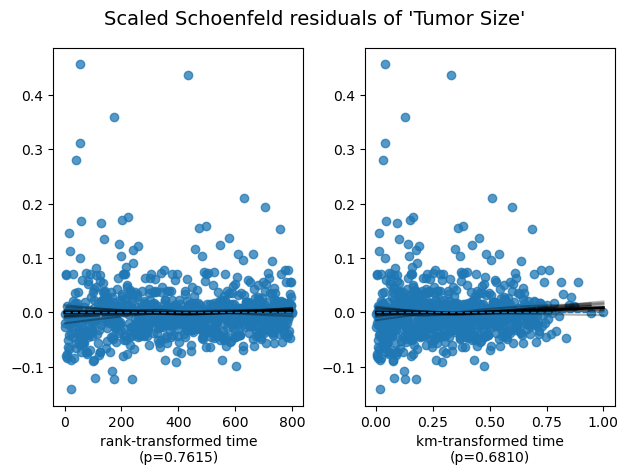

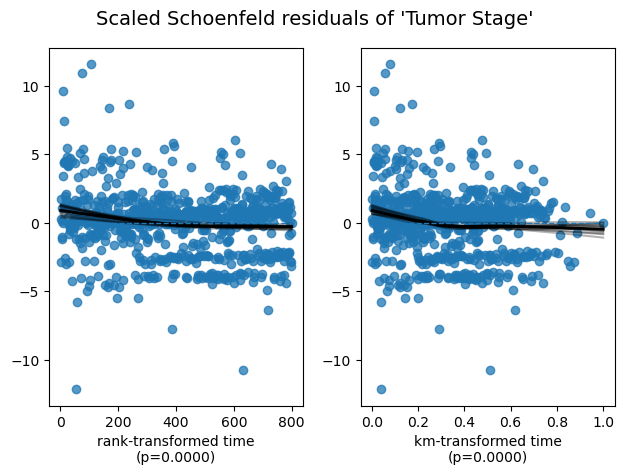

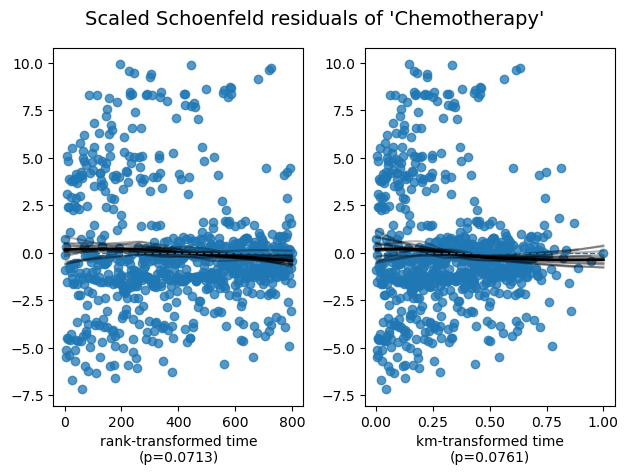

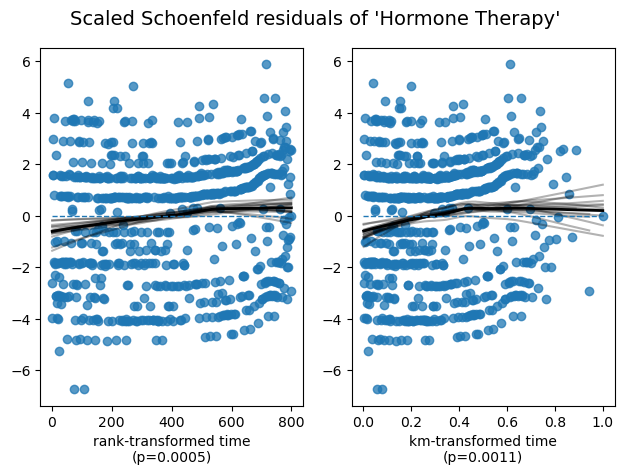

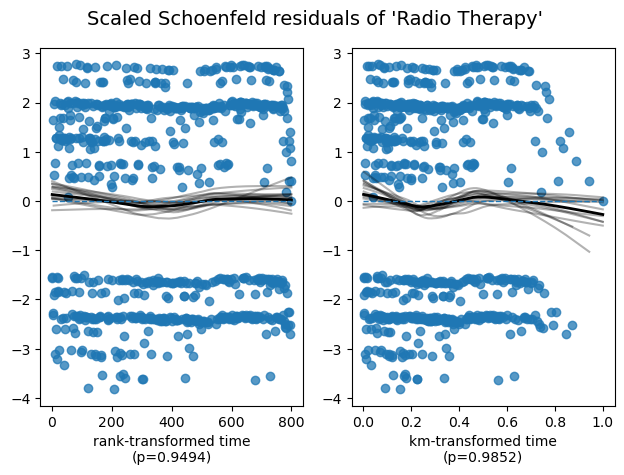

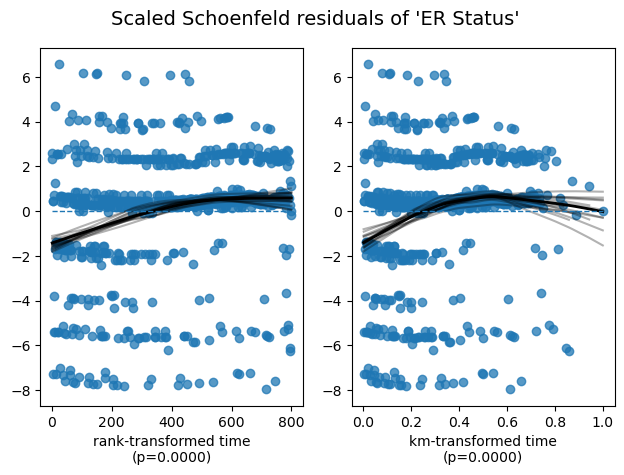

In [25]:
cph_multi.check_assumptions(
    CPH_train,
    p_value_threshold=0.05,
    show_plots=True
)


Tumor Size and Radio Therapy pass the PH test.  
**Tumor Stage does NOT pass the PH test!** We will therefore carry out stratification of the variable because it is a categorical variable. 

In [26]:
cph_strat = CoxPHFitter(penalizer=0.01)

cph_strat.fit(
    CPH_train,
    duration_col="time",
    event_col="event",
    strata=["Tumor Stage"]
)

cph_strat.print_summary()


c:\Users\lutox\miniconda3\Lib\site-packages\lifelines\fitters\__init__.py:1280: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, df_ in df.groupby(strata):
c:\Users\lutox\miniconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\lutox\miniconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True t

model,lifelines.CoxPHFitter
duration col,'time'
event col,'event'
penalizer,0.01
l1 ratio,0.0
strata,Tumor Stage
baseline estimation,breslow
number of observations,1386
number of events observed,800
partial log-likelihood,-4519.27
time fit was run,2025-12-04 19:45:43 UTC


In [27]:
print("--- Stratified Cox model summary ---")
cph_strat.print_summary(
    decimals=3,
    columns=["coef", "exp(coef)", "exp(coef) lower 95%", "exp(coef) upper 95%", "p"]
)

# 5) Concordance baseline
cindex_train = float(cph_strat.concordance_index_)
cindex_val = float(cph_strat.score(CPH_val, scoring_method="concordance_index"))
print(f"\nConcordance | train {cindex_train:.3f} | validation {cindex_val:.3f}")

--- Stratified Cox model summary ---


model,lifelines.CoxPHFitter
duration col,'time'
event col,'event'
penalizer,0.01
l1 ratio,0.0
strata,Tumor Stage
baseline estimation,breslow
number of observations,1386
number of events observed,800
partial log-likelihood,-4519.268
time fit was run,2025-12-04 19:45:43 UTC



Concordance | train 0.569 | validation 0.566


c:\Users\lutox\miniconda3\Lib\site-packages\lifelines\utils\__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")


**Forest Plot**

--- Forest Plot of Stratified Cox Model ---


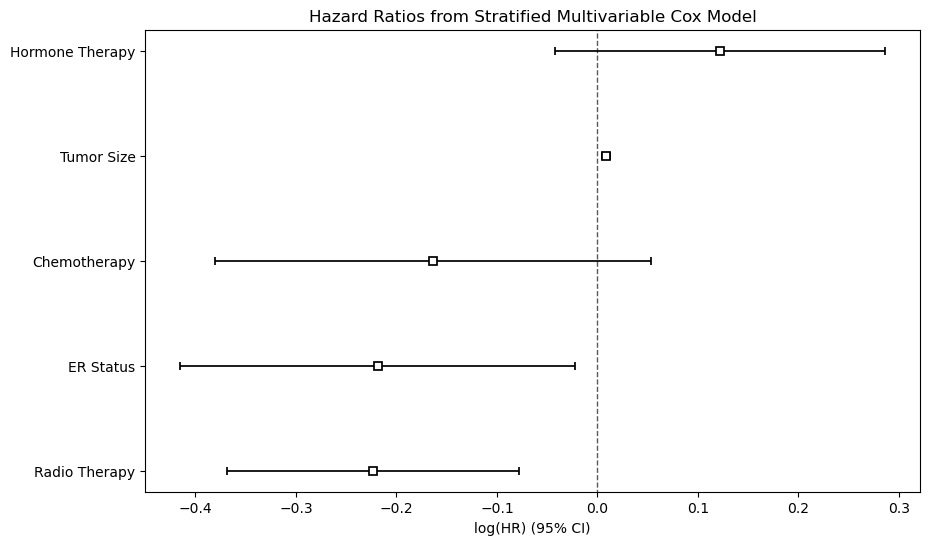

In [28]:
print("--- Forest Plot of Stratified Cox Model ---")
fig, ax = plt.subplots(figsize=(10, 6))

cph_strat.plot(ax=ax)

ax.set_title("Hazard Ratios from Stratified Multivariable Cox Model")
plt.show()

Forest plot shows us that Tumor Size still shows a **slight harmful effect** (although effect seems small tumor sizes vary in size) and Radio Therapy shows a **strong protective effect**  
ER Status **is now statistically significant and has a protective effect** something that was hidden before the stratification  
Chemotherapy and Hormone Therapy are not statistically significant

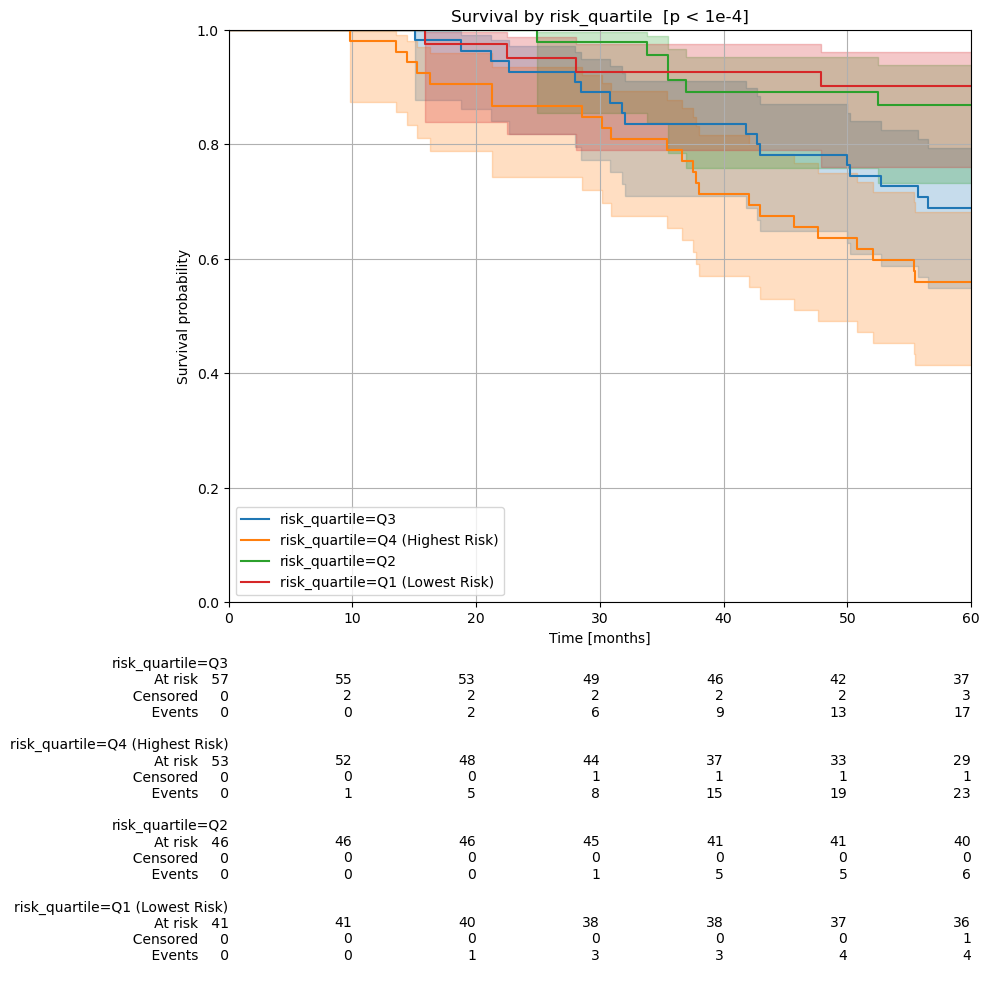

   test_statistic         p   -log2(p)
0       29.127843  0.000002  18.857683


In [29]:
# 1) Use the same processed data the model was trained on
X_train_cox = CPH_train.drop(columns=["time", "event"])
X_test_cox  = CPH_test.drop(columns=["time", "event"])

# 2) Compute risk scores
risk_train = cph_multi.predict_partial_hazard(X_train_cox).values
risk_test  = cph_multi.predict_partial_hazard(X_test_cox).values

# 3) Define quartiles based on *training* risks
q1, q2, q3 = np.quantile(risk_train, [0.25, 0.50, 0.75])
bins = [-np.inf, q1, q2, q3, np.inf]
labels = ["Q1 (Lowest Risk)", "Q2", "Q3", "Q4 (Highest Risk)"]

test_groups = pd.cut(risk_test, bins=bins, labels=labels, include_lowest=True)

# 4) Prepare survival data for test set
test_eval_df = pd.DataFrame({
    "duration": CPH_test["time"],
    "event": CPH_test["event"],
    "risk_quartile": test_groups
})

# 5) KM plot
fig, ax, logrank = utils.km_by_group(
    df=test_eval_df,
    group_col="risk_quartile",
    time_col="duration",
    event_col="event",
    xmax=60,
    show_table=True,
    figsize=(10, 10)
)

plt.show()

if logrank:
    print(logrank.summary)



Feature values for the selected low-risk and high-risk patients:


,Tumor Size,Tumor Stage,Chemotherapy,Hormone Therapy,Radio Therapy,ER Status
13,23.0,0.0,0.0,0.0,0.0,1.0
2,67.0,4.0,0.0,0.0,0.0,1.0


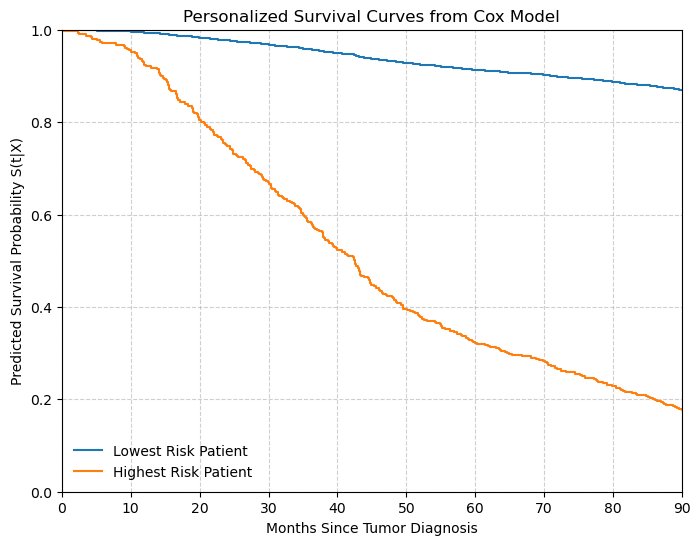


--- Fixed-Horizon Predictions ---



,Low-Risk Survival,Low-Risk Mortality,High-Risk Survival,High-Risk Mortality
7-Day,99.75%,0.25%,96.92%,3.08%
30-Day,96.80%,3.20%,66.87%,33.13%
60-Day,91.23%,8.77%,32.12%,67.88%


In [30]:
# 1. Find the index for the lowest and highest-risk patients in the TEST set
low_risk_idx  = X_test_cox.index[np.argmin(risk_test)]
high_risk_idx = X_test_cox.index[np.argmax(risk_test)]
patient_pair_df = X_test_cox.loc[[low_risk_idx, high_risk_idx]]

print("Feature values for the selected low-risk and high-risk patients:")
display(patient_pair_df)

# 2. Predict the full survival functions for these two patients
# The result is a DataFrame with time-points as the index and patients as columns
survival_functions = cph_multi.predict_survival_function(patient_pair_df)

# 3. Plot the personalized survival curves
plt.figure(figsize=(8, 6))
plt.step(survival_functions.index, survival_functions.iloc[:, 0], where="post", label="Lowest Risk Patient")
plt.step(survival_functions.index, survival_functions.iloc[:, 1], where="post", label="Highest Risk Patient")

plt.xlim(0, 90)
plt.ylim(0, 1)
plt.xlabel("Months Since Tumor Diagnosis")
plt.ylabel("Predicted Survival Probability S(t|X)")
plt.title("Personalized Survival Curves from Cox Model")
plt.legend(frameon=False)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 4. Extract survival probabilities and display them in a formatted table
eval_times = [7.0, 30.0, 60.0]
sf_at_times = cph_multi.predict_survival_function(patient_pair_df, times=eval_times)

# Create a clean DataFrame for the results
results_df = pd.DataFrame({
    'Low-Risk Patient': sf_at_times.iloc[:, 0].values,
    'High-Risk Patient': sf_at_times.iloc[:, 1].values
}, index=[f"{int(t)}-Day" for t in eval_times])

# Add mortality risk columns
results_df['Low-Risk Mortality'] = 1 - results_df['Low-Risk Patient']
results_df['High-Risk Mortality'] = 1 - results_df['High-Risk Patient']

# Rename survival columns for clarity
results_df.rename(columns={'Low-Risk Patient': 'Low-Risk Survival', 'High-Risk Patient': 'High-Risk Survival'}, inplace=True)

print("\n--- Fixed-Horizon Predictions ---\n")
# Display the styled DataFrame
display(results_df[['Low-Risk Survival', 'Low-Risk Mortality', 'High-Risk Survival', 'High-Risk Mortality']].style.format("{:.2%}").set_caption("Predicted Survival & Mortality Risk"))

In [31]:
# --- 1. Setup ---
eval_times = np.array([7.0, 30.0, 60.0], dtype=float)
y_train_surv = Surv.from_arrays(
    event=Y_train["event"].astype(bool).to_numpy(),
    time=Y_train["time"].to_numpy(dtype=float)
)
y_test_surv = Surv.from_arrays(
    event=Y_test["event"].astype(bool).to_numpy(),
    time=Y_test["time"].to_numpy(dtype=float)
)


# --- 2. Time-Dependent AUC (Corrected Logic) ---
def get_auc_at_time(t):
    """
    Robustly calculates AUC at a single time t, handling data insufficiency
    and varied output formats from the scikit-survival library.
    """
    # Check for sufficient data in both train and test sets
    events_train = Y_train["event"].astype(bool)
    times_train = Y_train["time"]
    train_ok = (events_train & (times_train <= t)).any() and (times_train > t).any()
    
    events_test = Y_test["event"].astype(bool)
    times_test = Y_test["time"]
    test_ok = (events_test & (times_test <= t)).any() and (times_test > t).any()
    
    if not (train_ok and test_ok):
        return np.nan
    
    # Calculate AUC
    raw_output = cumulative_dynamic_auc(y_train_surv, y_test_surv, risk_test, [t])
    
    # Handle inconsistent return formats from the library
    # Sometimes it returns a tuple (times, scores), sometimes just scores
    if isinstance(raw_output, tuple):
        auc_scores_array = raw_output[1]
    else:
        auc_scores_array = raw_output
        
    # Ensure the result is a 1D array and return the first (and only) score
    return np.atleast_1d(auc_scores_array)[0]

# Calculate AUC for each time point
auc_scores = [get_auc_at_time(t) for t in eval_times]


# --- 3. Brier Score Calculation ---
sf_at_times = cph_multi.predict_survival_function(X_test_cox, times=eval_times)
survival_prob_matrix = sf_at_times.T.to_numpy()
_, brier_scores = brier_score(y_train_surv, y_test_surv, survival_prob_matrix, eval_times)


# --- 4. Assemble and Display Results ---
performance_df = pd.DataFrame({
    "Time Horizon (Months)": eval_times.astype(int),
    "Time-Dependent AUC": auc_scores,
    "Brier Score": brier_scores
})

print("\n--- Time-Dependent Model Performance ---\n")
display(performance_df.style.format({
    "Time-Dependent AUC": "{:.3f}",
    "Brier Score": "{:.3f}"
}).hide(axis="index"))


--- Time-Dependent Model Performance ---



Time Horizon (Months),Time-Dependent AUC,Brier Score
7,nan,0.000
30,0.610,0.085
60,0.691,0.183


In our dataset there are no deaths before the 7 day mark which cause the NaN AUC score.  
At the 30 day mark **AUC: 0.610 shows that the model has a moderate discriminative ability** at predicting 30-day mortality. Low Brier score shows **good accuracy**.  
At the 60 day mark **AUC has improved significantly** but it comes at a cost of a higher Brier score, **lower accuracy**.

In [32]:
# Fit baseline Cox model (single event)
cph_baseline = CoxPHFitter(penalizer=0.01)

cph_baseline.fit(
    CPH_train, 
    duration_col="time", 
    event_col="event"
)

print("Baseline Cox Model Summary:")
cph_baseline.print_summary()



Baseline Cox Model Summary:


<lifelines.CoxPHFitter: fitted with 1386 total observations, 586 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1386
number of events observed = 800
   partial log-likelihood = -5147.94
         time fit was run = 2025-12-04 19:45:45 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
Tumor Size       0.01      1.01      0.00            0.00            0.01                1.00                1.01
Tumor Stage      0.54      1.71      0.08            0.39            0.69                1.47                1.99
Chemotherapy    -0.15      0.86      0.11           -0.37            0.06                0.69                1.06
Hormone Therapy  0.10      1.11      0.08           -0.06            0.27                0.94                1.31
Radio Therapy   -0.23      0.79      0.07           -0.37           -0.09                0.69                0.92
ER Status       -0.18      0.83      0.10           -0.38            0.02                0.69                1.02

                 cmp to     z      p  -log2(p)
covariate                                     
Tumor Size         0.00  4.03 <0.005     14.13
Tumor Stage        0.00  6.93 <0.005     37.81
Chemotherapy       0.00 -1.41   0.16      2.65
Hormone Therapy    0.00  1.25   0.21      2.23
Radio Therapy      0.00 -3.13 <0.005      9.18
ER Status          0.00 -1.81   0.07      3.82
---
Concordance = 0.63
Partial AIC = 10307.87
log-likelihood ratio test = 115.89 on 6 df
-log2(p) of ll-ratio test = 72.83

In [33]:
Y_test_cal = Y_test.rename(columns={"time": "duration_days", "event": "event_death"})

H = np.array([30.0, 60.0, 72.0])

pred_test = utils.predict_fixed_horizon_risk_from_cox(
    cph_model=cph_baseline,
    X_df=CPH_test.drop(columns=["time", "event"]),
    times=H
)

# Extract the risk columns
p30 = pred_test["Risk_30d"]
p60 = pred_test["Risk_60d"]
p72 = pred_test["Risk_72d"]

# Align predictions to Y_test index
p30 = pd.Series(p30.values, index=Y_test.index)
p60 = pd.Series(p60.values, index=Y_test.index)
p72 = pd.Series(p72.values, index=Y_test.index)

calib_30 = utils.check_calibration_fixed_horizon(
    y_true=Y_test_cal,
    predictions=p30,
    horizon_days=30.0,
    n_bins=4
).rename(columns={
    "pred_mean_risk": "pred_mean_risk_30m",
    "obs_risk": "obs_risk_30m"
})
display(calib_30)

calib_60 = utils.check_calibration_fixed_horizon(
    y_true=Y_test_cal,
    predictions=p60,
    horizon_days=60.0,
    n_bins=4
).rename(columns={
    "pred_mean_risk": "pred_mean_risk_60m",
    "obs_risk": "obs_risk_60m"
})
display(calib_60)

calib_72 = utils.check_calibration_fixed_horizon(
    y_true=Y_test_cal,
    predictions=p72,
    horizon_days=72.0,
    n_bins=4
).rename(columns={
    "pred_mean_risk": "pred_mean_risk_72m",
    "obs_risk": "obs_risk_72m"
})
display(calib_72)


,risk_quartile,n,pred_mean,obs_rate
0,Q1 lowest,49,0.050505,0.061224
1,Q2,48,0.077513,0.041667
2,Q3,49,0.091976,0.102041
3,Q4 highest,48,0.142431,0.166667


,risk_quartile,n,pred_mean,obs_rate
0,Q1 lowest,48,0.135706,0.104167
1,Q2,48,0.203567,0.166667
2,Q3,48,0.238614,0.312500
3,Q4 highest,48,0.346776,0.458333


,risk_quartile,n,pred_mean,obs_rate
0,Q1 lowest,47,0.160398,0.170213
1,Q2,49,0.236308,0.183673
2,Q3,45,0.274953,0.377778
3,Q4 highest,46,0.394785,0.500000


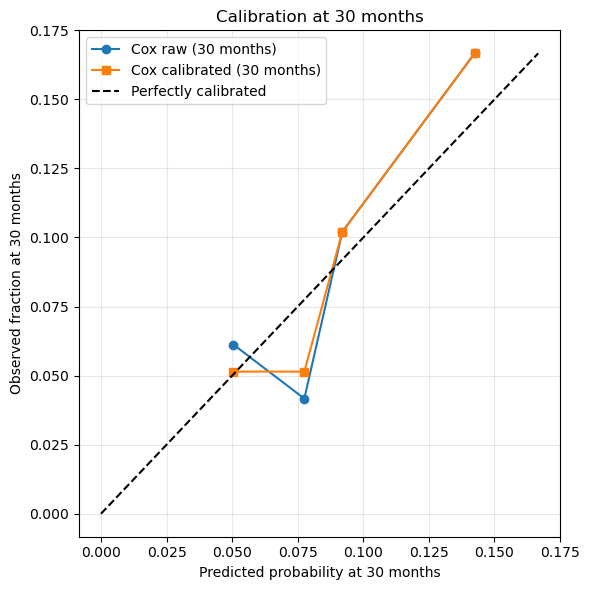

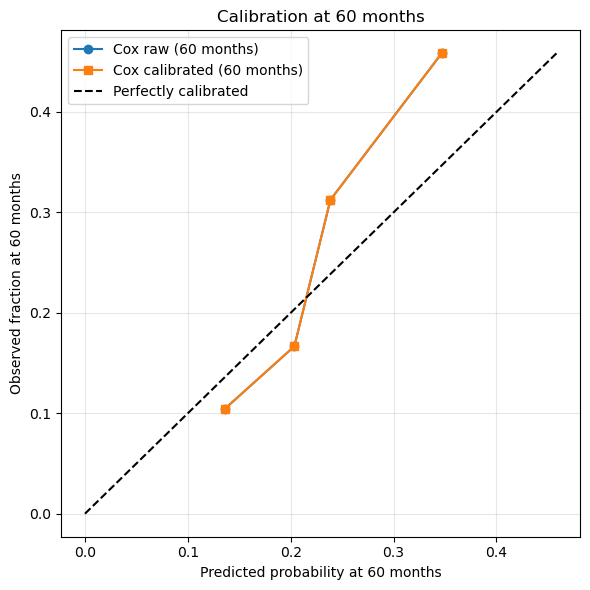

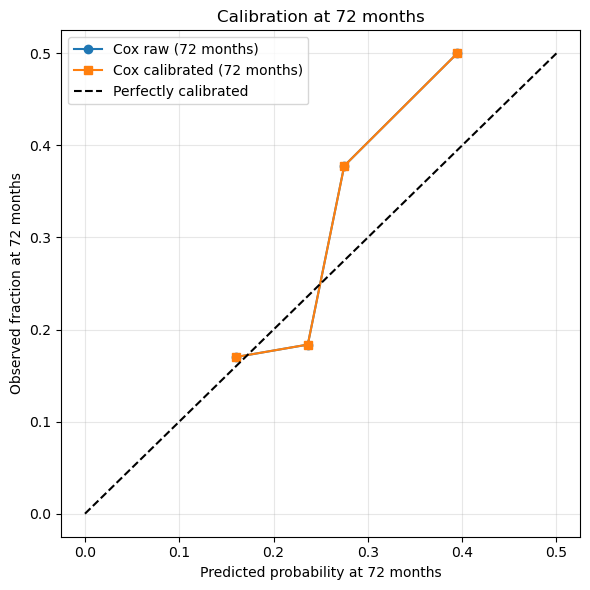

In [48]:
def calibrate_isotonic(pred, obs):
    """
    Fits isotonic regression to map predicted probabilities -> calibrated probabilities.
    Returns:
        calibrated_predictions, fitted_isotonic_model
    """
    ir = IsotonicRegression(out_of_bounds="clip")
    ir.fit(pred, obs)
    return ir.predict(pred), ir


def plot_calibration_with_isotonic(calib_df, horizon_label):
    
    # Identify prediction and observed columns automatically
    pred_col = [c for c in calib_df.columns if c.startswith("pred")][0]
    obs_col  = [c for c in calib_df.columns if c.startswith("obs")][0]

    x_raw = calib_df[pred_col].values
    y_obs = calib_df[obs_col].values

    # Fit isotonic regression (calibrated curve)
    y_calibrated, ir = calibrate_isotonic(x_raw, y_obs)

    # Create monotonic calibrated curve sorted by prediction
    x_sorted = np.sort(x_raw)
    y_cal_sorted = ir.predict(x_sorted)

    # Plot
    plt.figure(figsize=(6, 6))

    # Raw Cox curve
    plt.plot(x_raw, y_obs, '-o', label=f"Cox raw ({horizon_label})")

    # Calibrated curve
    plt.plot(x_sorted, y_cal_sorted, '-s', label=f"Cox calibrated ({horizon_label})")

    # Perfect calibration curve
    max_val = max(max(x_raw), max(y_obs))
    plt.plot([0, max_val], [0, max_val], 'k--', label="Perfectly calibrated")

    # Formatting
    plt.xlabel(f"Predicted probability at {horizon_label}")
    plt.ylabel(f"Observed fraction at {horizon_label}")
    plt.title(f"Calibration at {horizon_label}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_calibration_with_isotonic(calib_30, "30 months")
plot_calibration_with_isotonic(calib_60, "60 months")
plot_calibration_with_isotonic(calib_72, "72 months")



## Decisions Tree and Random Forest Models